This notebook contains the code to download and run machine learning models on the letter recognition data set that I am modelling for my dissertation. The results and graphs found in the final report were generated with this notebook.

In [1]:
# General
import urllib
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time

# Scikit learn 
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score

# Keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2

In [2]:
# Setting the random seed to obtain reproducible results
np.random.seed(1)

In [3]:
# Download the information file for the data set
info_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.names"
info_filename = "letter-recognition.names"
urllib.request.urlretrieve(info_url, info_filename)
with open(r'letter-recognition.names') as f:
    print(f.read())

# Manually create a list of column names for the data frame    
column_names = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 
                'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

1. Title: Letter Image Recognition Data 

2. Source Information
   -- Creator: David J. Slate
     -- Odesta Corporation; 1890 Maple Ave; Suite 115; Evanston, IL 60201
   -- Donor: David J. Slate (dave@math.nwu.edu) (708) 491-3867   
   -- Date: January, 1991

3. Past Usage:
   -- P. W. Frey and D. J. Slate (Machine Learning Vol 6 #2 March 91):
	"Letter Recognition Using Holland-style Adaptive Classifiers".

   	The research for this article investigated the ability of several
	variations of Holland-style adaptive classifier systems to learn to
	correctly guess the letter categories associated with vectors of 16
	integer attributes extracted from raster scan images of the letters.
	The best accuracy obtained was a little over 80%.  It would be
	interesting to see how well other methods do with the same data.

4. Relevant Information:

   The objective is to identify each of a large number of black-and-white
   rectangular pixel displays as one of the 26 capital letters in the English
 

In [4]:
# Download the data set
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
data_filename = "letter-recognition.data"
urllib.request.urlretrieve(data_url, data_filename)

# Create a dataframe using the data and column names
df = pd.read_csv(r'letter-recognition.data', sep=",", names=column_names)

# Data analysis

In [5]:
df.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lettr   20000 non-null  object
 1   x-box   20000 non-null  int64 
 2   y-box   20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   high    20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   x-bar   20000 non-null  int64 
 7   y-bar   20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybr   20000 non-null  int64 
 12  xy2br   20000 non-null  int64 
 13  x-ege   20000 non-null  int64 
 14  xegvy   20000 non-null  int64 
 15  y-ege   20000 non-null  int64 
 16  yegvx   20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


Mean count:  769.2307692307693
Standard deviation of counts:  22.724618457163782
Range of counts:  79
U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
N    783
Q    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
H    734
Z    734
Name: lettr, dtype: int64


Text(0, 0.5, 'Number of occurrences')

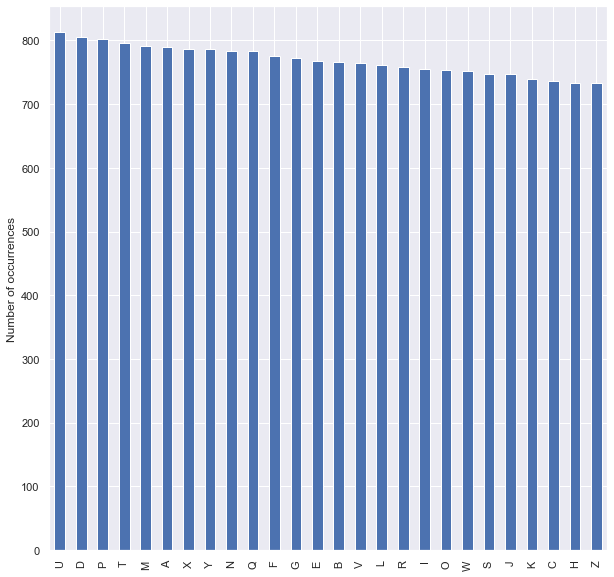

In [7]:
# View frequency of each letter in the data
letter_counts = df['lettr'].value_counts()
print("Mean count: ", np.mean(letter_counts))
print("Standard deviation of counts: ", np.std(letter_counts))
print("Range of counts: ", np.max(letter_counts) - np.min(letter_counts))
print(letter_counts)

# Plot the results
%matplotlib inline
plt.figure(figsize=(10,10))
letter_counts.plot(kind='bar')
plt.ylabel('Number of occurrences')

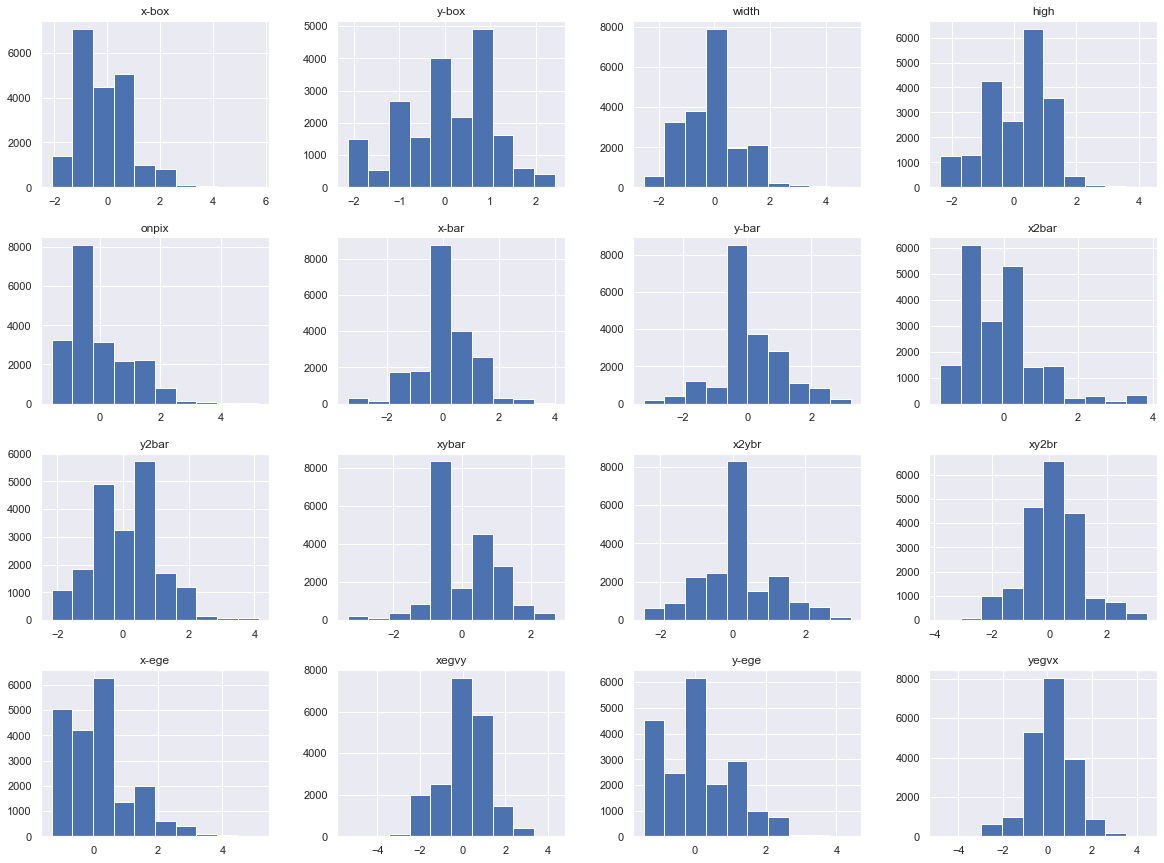

In [8]:
# Z-score standardiser
def standardise(x):
    return (x - x.mean()) / x.std()

# Standardise each covariate
for col in df.columns[1:]:
    df[col] = standardise(df[col])

# Plot historgrams of the covariate distributions
%matplotlib inline
df.hist(bins=10, figsize=(20,15))
plt.show()

<AxesSubplot:>

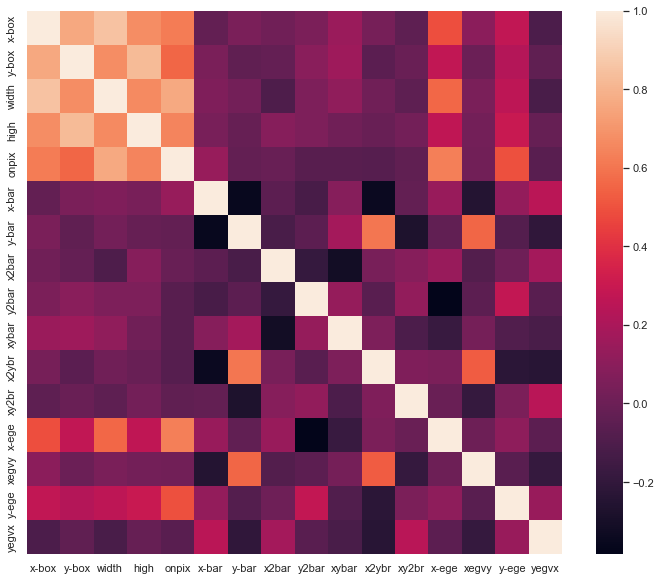

In [9]:
# Generate the correlation matrix
corrmx = df.corr()

# Plot the correlation matrix as a heatmap
%matplotlib inline
plt.figure(figsize=(12,10))
sns.heatmap(corrmx, xticklabels=corrmx.columns, yticklabels=corrmx.columns)

We can note that there is no missing data (every attribute has 20,000) non-null values. There is a sufficiently large amount of data to theoretically obtain good results. There is a narrow range of counts (79) and only ~22 standard deviation. Some variables (x-bar, y-bar, y2bar, x2ybr, xy2br, xegvy, yegvx) seem to have a normal distribution, but other look right or left tailed. This will be something to consider when using Gaussian NB.

# Modelling the data

## Creating the training and testing sets

In [41]:
# Find the indices for training and testing sets
random_indices = np.random.permutation(len(df))
train_size = int(len(df) * 0.8)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:]

# Split the data into training and testing tests
df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

# Create the training/testing inputs and labels
train_X, train_y = df_train.iloc[:, 1 :len(df_train.columns)], df_train.iloc[:,0]
test_X, test_y = df_test.iloc[:, 1 :len(df_test.columns)], df_test.iloc[:,0]

In [ ]:
def median_range(ls):
    ls_sorted = ls.sort()
    range = ls[len(ls)-1] - ls[0]
    if len(ls) % 2 != 0:
        m = int((len(ls)+1)/2 - 1)
        return (ls[m], range)
    else:
        m1 = int(len(ls)/2 - 1)
        m2 = int(len(ls)/2)
        return ((ls[m1]+ls[m2])/2, range)

## Multinomial logistic regression

In [ ]:
params = {"C":np.logspace(-3,3,20)}

lr = LogisticRegression(multi_class='ovr', solver='newton-cg', penalty='l2', max_iter=100)
grid_lr = GridSearchCV(lr, params)
grid_lr.fit(train_X, train_y)
print(grid_lr.best_params_)

In [ ]:
lr = LogisticRegression(multi_class='ovr', solver='newton-cg', penalty='l2', max_iter=100, C=2.976351441631316)
lr.fit(train_X, train_y)
lr_pred = lr.predict(test_X)
print('Accuracy score: ', metrics.accuracy_score(test_y, lr_pred))

In [ ]:
# Plot a confusion matrix
lr_confmx = metrics.confusion_matrix(test_y, lr_pred, labels=lr.classes_)

%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(lr_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(lr.classes_)
ax.yaxis.set_ticklabels(lr.classes_)
plt.show()

## Gaussian Naive-Bayes

We'll first attempt Gaussian Naive-Bayes on the total data set. We don't expect great results as we know there is a strong correlation between some of the covariates.

In [42]:
# Create and validate the Gaussian Naive-Bayes model
nb = naive_bayes.GaussianNB()
print(np.mean(cross_val_score(nb, train_X, train_y, cv=5))) # 5-fold cross validation 

0.6411875


~0.63 averaged accuracy on validation sets. We will fit the model and test performance on the test set.

In [43]:
# Fit the model
nb.fit(train_X, train_y)   

# Predict on testing set and print accuracy
nb_pred = nb.predict(test_X)
print('Accuracy score: ', metrics.accuracy_score(test_y, nb_pred))

Accuracy score:  0.64125


~0.65 accuracy on test performance. We can try and identify some mistakes from the confusion matrix.

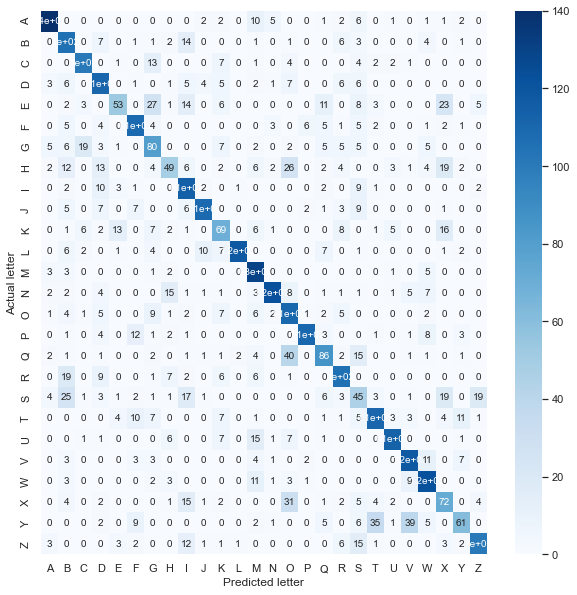

In [44]:
# Plot a confusion matrix
nb_confmx = metrics.confusion_matrix(test_y, nb_pred, labels=nb.classes_)
%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(nb_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(nb.classes_)
ax.yaxis.set_ticklabels(nb.classes_)
plt.show()

There is no obvious pattern to the mistakes the model has made. We will try to improve performance by dropping the highly correlated covariates.

### Removing highly correlated covariates

Now we will remove the first five explanatory variables, in attempt to reduce correlation between covariates.

In [45]:
# Dropping highly correlated variables from  training and testing set
train_X_2 = train_X.drop(['x-box', 'y-box', 'width', 'high', 'onpix'], axis=1)
test_X_2 = test_X.drop(['x-box', 'y-box', 'width', 'high', 'onpix'], axis=1)

In [46]:
# Validate the model on the new training and testing sets
print(np.mean(cross_val_score(nb, train_X_2, train_y, cv=5))) # 5-fold cross validation 

0.6560625


There is roughly a 2% increase in validation accuracy, so the model appears valid. We will predict on the testing set

In [35]:
# Fit the model
nb.fit(train_X_2, train_y)

# Predict on the test set and print accuracy
nb_pred2 = nb.predict(test_X_2)
print('Accuracy score: ', metrics.accuracy_score(test_y, nb_pred2))

Accuracy score:  0.667


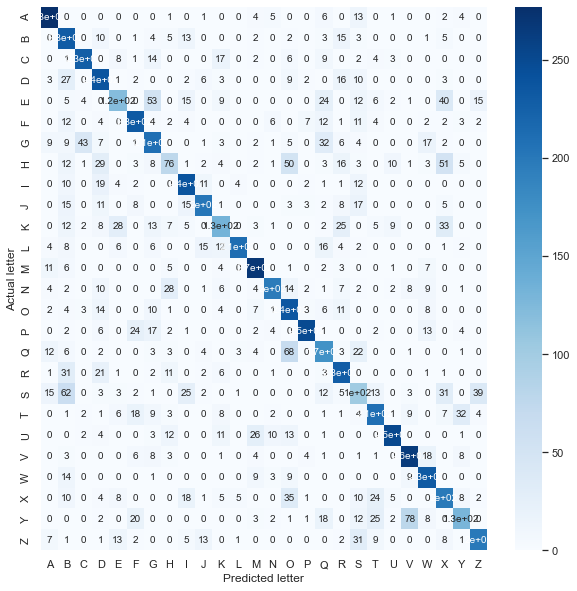

In [36]:
# Plot a confusion matrix
nb_confmx2 = metrics.confusion_matrix(test_y, nb_pred2, labels=nb.classes_)

%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(nb_confmx2, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(nb.classes_)
ax.yaxis.set_ticklabels(nb.classes_)
plt.show()

The Gaussian Naive-Bayes assumptions do not appear to fit the data well.

## K-Nearest-Neighbours

In [47]:
# Identify the best value of K
params = {'n_neighbors': np.arange(1,11,1)}
knn = KNeighborsClassifier() # Create the model
grid_knn = GridSearchCV(knn, params)
grid_knn.fit(train_X, train_y)
print(grid_knn.best_params_)

{'n_neighbors': 1}


In [48]:
# Validate the model
knn = KNeighborsClassifier(n_neighbors=1)
print(np.mean(cross_val_score(knn, train_X, train_y, cv=5)))

0.94375


\>90% accuracy is impressive. We will find the accuracy on the testing set.

In [49]:
# Fit the model 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

# Predict on the testing set and print accuracy
knn_pred = knn.predict(test_X)
print('Accuracy score: ', metrics.accuracy_score(test_y, knn_pred))

Accuracy score:  0.95575


In [ ]:
# Plot a confusion matrix
knn_confmx = metrics.confusion_matrix(test_y, knn_pred, labels=knn.classes_)
%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(knn_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(knn.classes_)
ax.yaxis.set_ticklabels(knn.classes_)
plt.show()

# Neural networks

## Preparing the data

We'll begin by converting our data labels to one-hot encodings, as Keras does not do this for us automatically. We'll then convert the data to numpy arrays as these are simple to work with and can be fed straight to Keras neural networks.

In [13]:
# One-hot encode the training and testing sets for use as tensors in 
# our neural networks
train_onehot_labels = pd.get_dummies(train_y)
test_onehot_labels = pd.get_dummies(test_y)

In [14]:
# Convert the data to arrays
train_inputs = train_X.to_numpy()
train_labels = train_onehot_labels.to_numpy()
test_inputs = test_X.to_numpy()
test_labels = test_onehot_labels.to_numpy()

## Model validation

### Baseline model

We shall begin by creating a relatively small neural network to serve as our baseline. We will compare this against models with larger numbers of hidden neurons and using regularisation. We've chosen two hidden layers, each with 20 neurons (chosen as a round number between 16 and 26). We'll use 5-fold cross-validation to compare the categorical cross-entropy loss of the models.

In [15]:
# Compiling a baseline network to compare networks to.
# We have used the He initialization method, Adam optimization
# and categorical cross-entropy loss function
base_model = models.Sequential()
base_model.add(layers.Dense(20, activation='relu', input_shape=(16,), 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.add(layers.Dense(20, activation='relu', 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.add(layers.Dense(26, activation='softmax', 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
base_model.save_weights('initial_weights1') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                           # cross-validation)

Average accuracy on validation set:  0.853083324432373


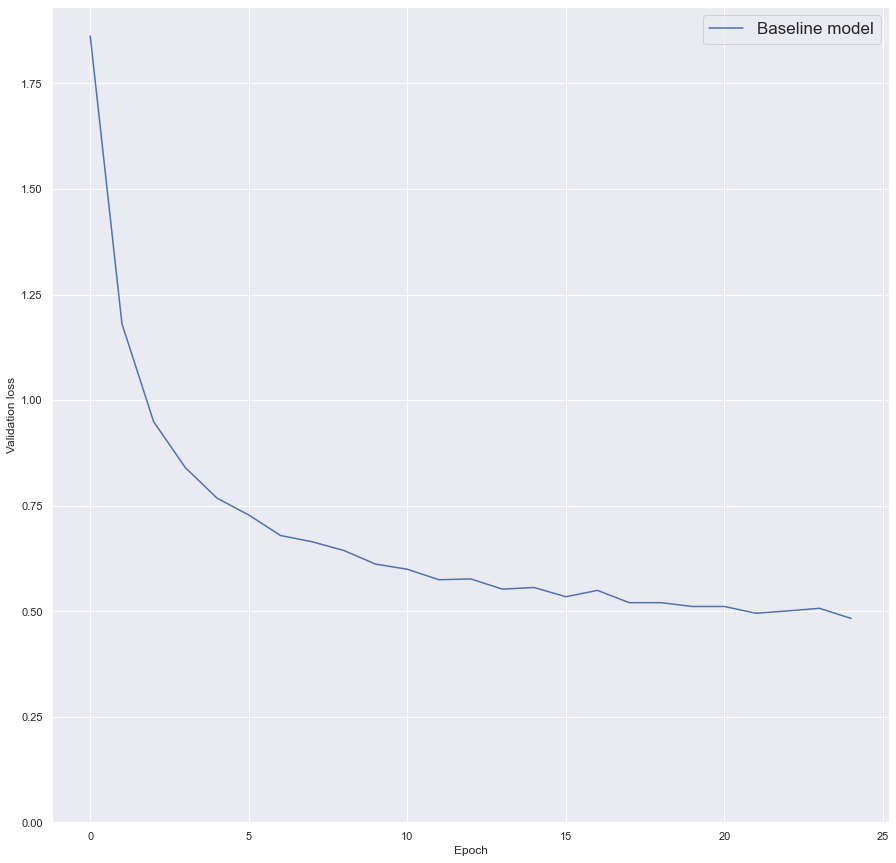

In [16]:
# Training the network with K-fold cross-validation
k = 5
validation_size = len(train_X) // k
validation_loss1 = []
validation_accuracy1 = []
for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]
    
    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)
    
    # Train the model
    # Reset the weights and biases after each fold
    base_model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', metrics=['accuracy'])
    history = base_model.fit(partial_train_inputs, partial_train_labels, 
                   validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss1.append(history.history['val_loss'])
    validation_accuracy1.append(history.history['val_accuracy'][24])
    base_model.load_weights('initial_weights1')
    
# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy1))

# Plot validation loss vs epoch
epochs = np.linspace(0,24,25)
val_loss1_1 = validation_loss1[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

We find an average accuracy score in 5-fold cross-validation of ~0.85, so our model is feasible, and we will use it as our baseline. We will plot validation loss vs epoch curves of our larger and regularised models against this curve. As we have not observed overfitting, we shall proceed by increasing the capacity of the model to allow the model to learn the features more closely. We will not attempt a smaller model for this reason.

### Higher capacity model

In [17]:
# Create a model with a higher number of neurons in each layer.
model2 = models.Sequential()
model2.add(layers.Dense(100, activation='relu', input_shape=(16,), 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model2.save_weights('initial_weights2') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9338333368301391


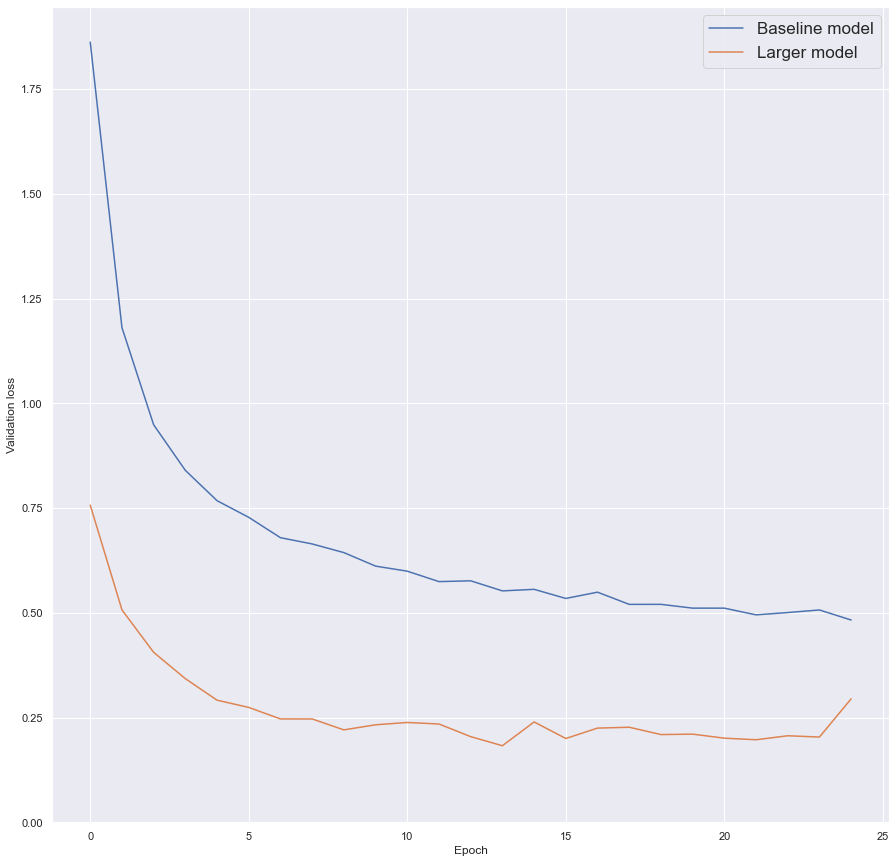

In [18]:
# Training the network with 5-fold cross-validation
validation_loss2 = []
validation_accuracy2 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model2.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model2.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss2.append(history.history['val_loss'])
    validation_accuracy2.append(history.history['val_accuracy'][24])
    model2.load_weights('initial_weights2')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy2))

# Plot validation loss vs epoch
val_loss2_1 = validation_loss2[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

This more complex model has ~95% average validation accuracy.  We can identify that the model seems to be slightly overfitting in the later epochs, as the validation loss is trendingly slightly upwards. We will introduce L2 regularisation in an attempt to reduce this overfitting.

### Regularising the model

In [23]:
# Add L2 regularisation to the model from the previous section.
model3 = models.Sequential()
model3.add(layers.Dense(100, activation='relu', input_shape=(16,), 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model3.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model3.save_weights('initial_weights3') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9309166550636292


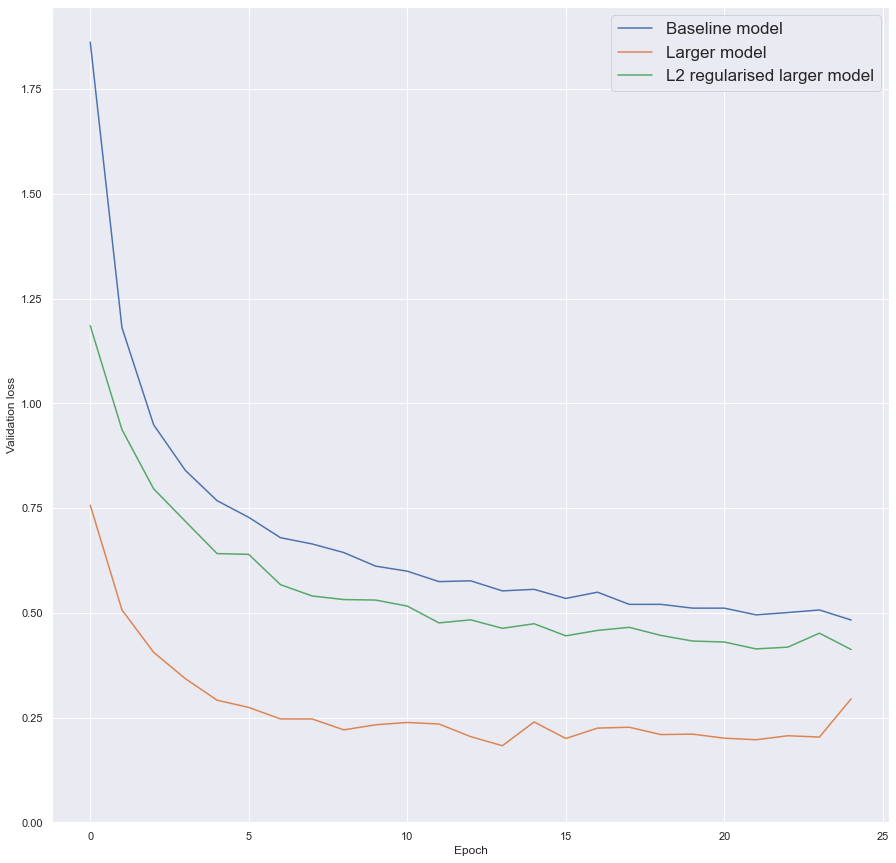

In [24]:
# Training the network with 5-fold cross-validation
validation_loss3 = []
validation_accuracy3 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model3.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model3.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss3.append(history.history['val_loss'])
    validation_accuracy3.append(history.history['val_accuracy'][24])
    model3.load_weights('initial_weights3')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy3))

# Plot validation loss vs epoch
val_loss3_1 = validation_loss3[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.plot(epochs, val_loss3_1, label = 'L2 regularised larger model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

We observe that the model with L2 regularisation shows validation loss decreasing across the training epochs (despite some fluctuations), whereas the unregularised model is steadily increasing in validation loss at each training epoch. Despite this, the unregularised model has lower validation loss at every epoch than the regularised model. It seems that the regularised model prevents the model from overfitting, but is still out performed by the unregularised model at this level of model complexity. We will now attempt dropout.

In [25]:
model4 = models.Sequential()
model4.add(layers.Dense(100, activation='relu', input_shape=(16,), 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model4.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model4.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model4.save_weights('initial_weights4') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9309166550636292


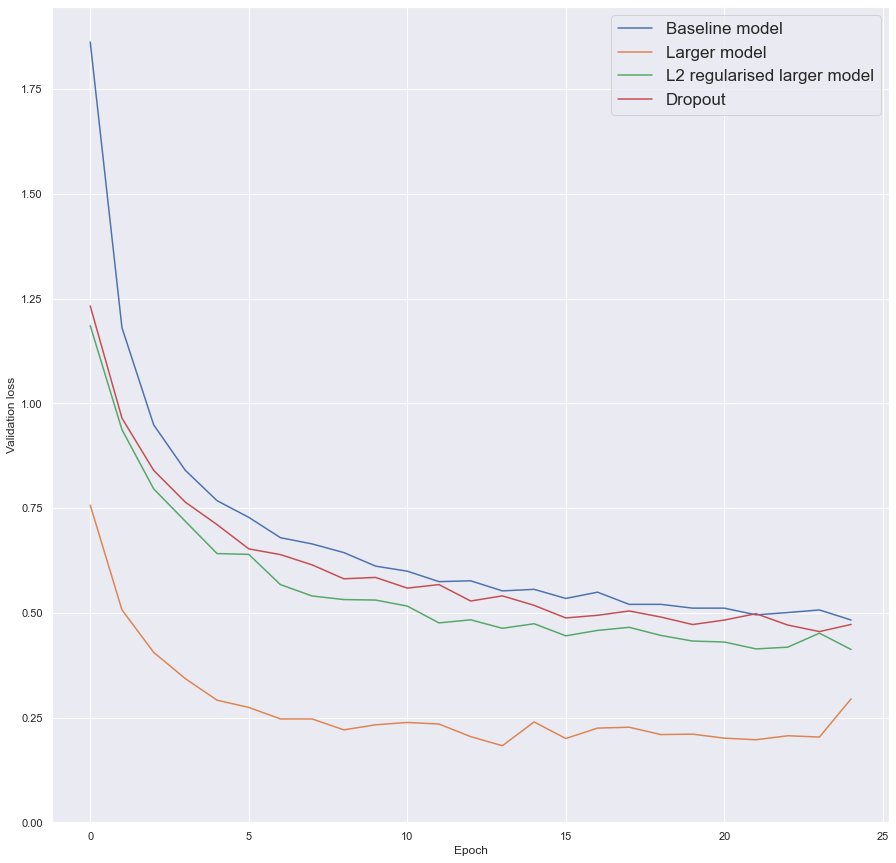

In [26]:
# Training the network with 5-fold cross-validation
validation_loss4 = []
validation_accuracy4 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model4.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model4.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss4.append(history.history['val_loss'])
    validation_accuracy4.append(history.history['val_accuracy'][24])
    model4.load_weights('initial_weights4')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy3))

# Plot validation loss vs epoch
val_loss4_1 = validation_loss4[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.plot(epochs, val_loss3_1, label = 'L2 regularised larger model')
ax.plot(epochs, val_loss4_1, label = 'Dropout')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

We in fact see no better long-term performance in the larger network with dropout than the baseline model. We continue to see long-term overfitting by the unregularised model despite better performance at every epoch. We might conclude that with greater training epochs and training data size that the regularised models will outperform the unregularised model, as the latter appears most susceptible to overfitting.

Despite the surprisingly poor performance of the regularised models, each network appears to be at least a valid way to model the data, so we will compare the peformance in accuracy when predicting on the unseen testing set.

## Evaluating the models

In [27]:
model2.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
_, model2_acc = model2.evaluate(test_inputs, test_labels)
print('Unregularised model accuracy score: ', model2_acc)

250/250 [==============================] - 0s 1ms/step - loss: 0.2068 - accuracy: 0.9582
Unregularised model accuracy score:  0.9582499861717224


In [28]:
model3.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
_, model3_acc = model3.evaluate(test_inputs, test_labels)
print('L2 regularised model accuracy score: ', model3_acc)

250/250 [==============================] - 0s 1ms/step - loss: 0.3728 - accuracy: 0.9377
L2 regularised model accuracy score:  0.937749981880188


In [29]:
model4.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
_, model4_acc = model4.evaluate(test_inputs, test_labels)
print('Dropout model accuracy score: ', model4_acc)

250/250 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.9255
Dropout model accuracy score:  0.9254999756813049


Despite the better performance of the unregularised model in validation loss, we find the accuracy on the testing set between the models negligible. As a result, we may be inclined to conclude that the regularised models are the better models as they are likely to have greater generalisation power as more training data is learned by the model.